# Explainable AI, Homework 2, Task A

## `dalex` and `shap` comparison for sample 1.
The results below are obtained for an XGBoost model.

We can see that, for sample 1, the packages mostly agree about the input of the variables. The ranking of the variables is similar, with the signs of values in agreement for the top 10 variables, and minor differences in the values themselves.

The vast majority of the contributions here are negative, which is related to the model prediction being low (0.009) for this sample.

![alt text](3_dalex_x1.png "Title")

![alt text](3_shap_x1.png "Title")

## `dalex` and `shap` comparison for sample 2.
Again, the two packages mostly agree in their results. The top 7 variables are the same in both cases, with differences appearing for variables with SHAP values below 0.03. We can interpret this as suggesting that the results are actually meaningful, and the small changes result from numerical stability and/or differences in sampling.

The vast majority of the contributions here are positive, which is related to the model prediction being high (0.978) for this sample.

![alt text](3_dalex_x2.png "Title")

![alt text](3_shap_x2.png "Title")

## Different variables of highest importance

`dalex` waterfall plots for the same pair of samples are included below.

We can see that the two samples have different variables of highest importance: we have the top 2 for sample 1 as `chol` and `thall_2`, while for sample 2 the top 2 is `oldpeak` and `thall_3`. While we can see that the two `thall` variables represent different values of the same strong predictor, the strongest predictors are significantly different. We can infer that, for different samples, different variables are crucial for making predictions.

![alt text](3_dalex_x1.png "Title")

![alt text](3_dalex_x2.png "Title")

## Different attribution signs
We can see in the plots above that the SHAP values for the `chol` variable have different signs. The variable is an important predictor for both samples, having the largest absolute Shapley value for sample 1, and a value in the top 3 for sample 2. We can guess that, since the attributions are both important and contrasting, the `chol` value is part of the variables that create a difference between the two samples' contrasting predictions.

## Package differences
Comparing the results between packages, we can see that all the conclusions remain valid. The difference in values does not translate into a qualitative difference in conclusions.

## Logistic regression explanations

Below we can find plots for logistic regression explanations for the same two samples as chosen above for the XGBoost model. 

The values of the predictions for the two samples don't change much - we get 0.014 and 0.934 instead of 0.009 and 0.978.

There is a bigger difference between the top variables between the models than between the packages. For example, the `chol` variable falls down in importance for sample 1.

![alt text](7_x1.png "Title")

![alt text](7_x2.png "Title")

## Different attributions for XGBoost and logistic regression

Below, we can see plots for a sample that has been selected as having different attributions for the two model types.

The predictions themselves differ quite a bit - we have 0.946 for XGBoost and 0.487 for logistic regression. This brings a change in the SHAP values. We can see that the `age` variable has a different impact for the two models, with the values' signs being different.

![alt text](7_xgboost.png "Title")

![alt text](7_lr.png "Title")

# Task B

We have
v() = 0

v(A) = 20

v(B) = 20

v(C) = 60

v(A,B) = 60

v(A,C) = 70

v(B,C) = 70

v(A,B,C) = 100

For A, B, C we have permutations:
* A, B, C
* A, C, B
* B, A, C
* B, C, A
* C, A, B
* C, B, A

We thus have:

f(A) = (1/6) * ( 2 * (v(A) - v()) + (v(A, B) - v(B)) + (v(A, C) - v(C)) + 2 * (v(A, B, C) - v(B, C)) = (1/6) * (40 + 40 + 10 + 60) = 150 / 6 = 25

and, analogically,

f(B) = (1/6) * (40 + 40 + 10 + 60) = 150 / 6 = 25

f(C) = (1/6) * (120 + 50 + 50 + 80) = 300 / 6 = 50

# Appendix

In [1]:
!pip install dalex --quiet
!pip install shap==0.41.0 --quiet

In [187]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import xgboost
import dalex as dx
import shap

import warnings
warnings.filterwarnings("ignore")

In [188]:
DATA_PATH = "/content/heart.csv"
CATEGORICAL_COLUMNS = ['sex', 'cp', 'fbs', 'restecg', 'caa', 'exng', 'slp', 'thall']
TARGET_COLUMN = 'output'

## Read in and prepare data

In [189]:
df = pd.read_csv(DATA_PATH)
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [190]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [191]:
for column in CATEGORICAL_COLUMNS:
    df[column] = df[column].astype(str)

#### Encode categorical features

In [192]:
df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output', 'sex_1',
       'cp_1', 'cp_2', 'cp_3', 'fbs_1', 'restecg_1', 'restecg_2', 'exng_1',
       'slp_1', 'slp_2', 'caa_1', 'caa_2', 'caa_3', 'caa_4', 'thall_1',
       'thall_2', 'thall_3'],
      dtype='object')

#### Select and normalise X and y

In [193]:
X = df.drop(columns = [TARGET_COLUMN])

In [195]:
y = df[TARGET_COLUMN]

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 7. Train logistic regression

In [200]:
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [201]:
logistic_regression = LogisticRegression().fit(X_scaled, y_train)

## 1. Train XGBoost

In [206]:
xgboost_model = xgboost.XGBClassifier(
    n_estimators=200, 
    max_depth=4, 
    use_label_encoder=False, 
    eval_metric="logloss"
)

In [207]:
xgboost_model.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', max_depth=4, n_estimators=200,
              use_label_encoder=False)

## 2. Select samples and calculate predictions.

In [214]:
k = 20
x1, y1 = X_test.iloc[0:1], y_test.iloc[0:1]
x2, y2 = X_test.iloc[k:k+1], y_test.iloc[k:k+1]

In [215]:
for x, y in zip((x1, x2), (y1, y2)):
    print(y)
    print(xgboost_model.predict_proba(x))
    print(xgboost_model.predict(x))

179    0
Name: output, dtype: int64
[[0.9907457  0.00925429]]
[0]
267    0
Name: output, dtype: int64
[[0.02206343 0.97793657]]
[1]


## 3. Calculate 2 decompositions for XGBoost
## 4. Choose samples with different highest importance variables
## 5. Select two samples for which a feature has different signs of attributions (chol)

### shap

In [216]:
shap_explainer = shap.explainers.Tree(xgboost_model, data=X_train, model_output="probability")

In [217]:
shap_values = shap_explainer(x1)

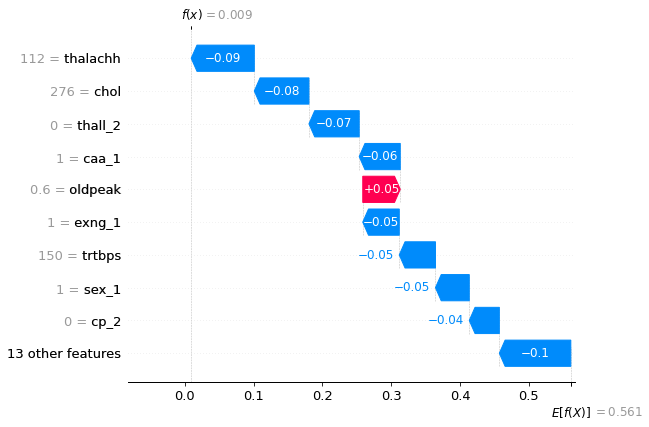

In [218]:
shap.plots.waterfall(shap_values[0])

In [219]:
shap_values = shap_explainer(x2)

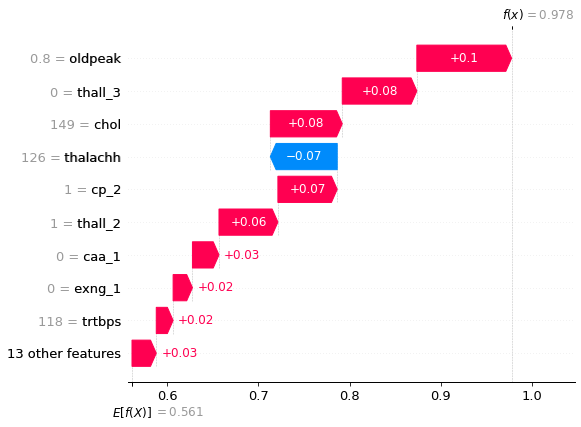

In [220]:
shap.plots.waterfall(shap_values[0])

### dalex

In [229]:
pf_xgboost_classifier_default = lambda m, d: m.predict_proba(d)[:, 1]

explainer = dx.Explainer(xgboost_model, X_train, predict_function=pf_xgboost_classifier_default, label="XGBoost")

Preparation of a new explainer is initiated

  -> data              : 242 rows 22 cols
  -> target variable   : Not specified!
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost
  -> predict function  : <function <lambda> at 0x7fbdffb29050> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000263, mean = 0.546, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> model_info        : package xgboost

A new explainer has been created!


In [252]:
shap_attributions = [explainer.predict_parts(x, type="shap") for x in (x1, x2)]

In [253]:
for attr in shap_attributions:
    attr.plot()

## 7. Explainer for another model type

In [224]:
logistic_explainer = dx.Explainer(logistic_regression, X_scaled, label="logistic regression", verbose=False)

In [225]:
for x in (x1, x2):
    print(logistic_regression.predict_proba(scaler.transform(x)))

[[0.98578788 0.01421212]]
[[0.06612066 0.93387934]]


In [254]:
shap_attributions = [logistic_explainer.predict_parts(scaler.transform(x), type="shap") for x in (x1, x2)]

In [255]:
for x, attr in zip((x1, x2), shap_attributions):
    attr.result.variable_name = attr.result.variable_name.apply(lambda a: x.columns[int(a)])
    attr.result.variable_value = attr.result.variable_name.apply(lambda a: x[a])
    attr.result.variable = attr.result.variable_name + " = " + attr.result.variable_value.astype(str)

In [256]:
for attr in shap_attributions:
    attr.plot()

In [257]:
index = 27
x = X_test.iloc[[index]]
shap_attributions = [explainer.predict_parts(x, type="shap"),
    logistic_explainer.predict_parts(scaler.transform(x), type="shap")]

for x, attr in ((x, shap_attributions[1]),):
    attr.result.variable_name = attr.result.variable_name.apply(lambda a: x.columns[int(a)])
    attr.result.variable_value = attr.result.variable_name.apply(lambda a: x[a])
    attr.result.variable = attr.result.variable_name + " = " + attr.result.variable_value.astype(str)

In [258]:
for attr in shap_attributions:
    attr.plot()